In [1]:
import numpy as np
from matplotlib import pyplot as plt

# seed the random number generator for deterministic runs
np.random.seed(42)

#### Optional: Use Legate timing to measure elapsed time
#### TODO: Add docstring

In [2]:
def initialize(n_elements, n_dims, n_centroids): 
    data = np.random.random((n_elements, n_dims))
    # Since points are random, we'll just generate some random centers
    centroids = np.random.random((n_centroids, n_dims))
    return data, centroids

In [3]:
def calculate_distances(data, centroids, data_dots):
    centroid_dots = np.square(np.linalg.norm(centroids, ord=2, axis=1))
    pairwise_distances = ( 
        data_dots[:, np.newaxis] + centroid_dots[np.newaxis, :]
    )   
    # ||x-y||^2 = ||x||^2 + ||y||^2 - 2 x . y
    # pairwise_distances has ||x||^2 + ||y||^2, so beta = 1
    # The gemm calculates x.y for all x and y, so alpha = -2.0
    pairwise_distances -= 2.0 * np.dot(data, centroids.T)
    return pairwise_distances

In [4]:
def relabel(pairwise_distances):
    return np.argmin(pairwise_distances, axis=1)

In [5]:
def find_centroids(
    centroids, data, labels, pairwise_distances, zero_point, n_centroids
):
    # Get the number of points associated with each centroid
    counts = np.bincount(labels, minlength=n_centroids)
    # Build label masks for each centroid and sum across all the
    # points assocated with each new centroid
    distance_sum = 0.0 
    for idx in range(n_centroids):
        # Boolean mask indicating where the points are for this center
        centroid_mask = labels == idx 
        centroids[idx, :] = np.sum(
            np.where(centroid_mask[..., np.newaxis], data, zero_point), axis=0
        )   
        distance_sum += np.sum(
            np.where(centroid_mask, pairwise_distances[:, idx], 0.0)
        )   
    # To avoid introducing divide by zero errors
    # If a centroid has no weight, we'll do no normalization
    # This will keep its coordinates defined.
    counts = np.maximum(counts, np.ones((1,), dtype=np.uint64))
    centroids /= counts[:, np.newaxis]
    return distance_sum

In [6]:
def run_kmeans(n_centroids, n_dims, n_iters, n_elements, n_iter_check):
    print("Running kmeans...")
    print("Number of data points: " + str(n_elements))
    print("Number of dimensions: " + str(n_dims))
    print("Number of centroids: " + str(n_centroids))
    print("Max iterations: " + str(n_iters))

    data, centroids = initialize(n_elements, n_dims, n_centroids)

    data_dots = np.square(np.linalg.norm(data, ord=2, axis=1))
    zero_point = np.zeros((1, data.shape[1]), dtype=data.dtype)

    labels = None
    iteration = 0 
    prior_distance_sum = None
    # We run for max iterations or until we converge
    # We only test convergence every n_iter_check iterations
    while iteration < n_iters:
        pairwise_distances = calculate_distances(data, centroids, data_dots)

        new_labels = relabel(pairwise_distances)

        distance_sum = find_centroids(
            centroids,
            data,
            new_labels,
            pairwise_distances,
            zero_point,
            n_centroids,
        )   

        if iteration > 0 and iteration % n_iter_check == 0:
            changes = np.not_equal(labels, new_labels)
            total_changes = np.sum(changes)
            delta = distance_sum / prior_distance_sum
            if delta > 1 - 0.000001:
                break
                
        prior_distance_sum = distance_sum
        labels = new_labels
        iteration += 1

    return data, labels

In [7]:
n_centroids = 5
n_dims = 2
n_elements = 256
n_iter_check = 10
n_iters = 100

data, labels = run_kmeans(n_centroids, n_dims, n_iters, n_elements, n_iter_check)

Running kmeans...
Number of data points: 256
Number of dimensions: 2
Number of centroids: 5
Max iterations: 100


In [8]:
label_color_map = {0: 'blue', 1: 'black', 2: 'red', 3: 'magenta', 4:'yellow', 5: 'green', 6:'gray'}

# make sure we have unique color for each cluster (total number of clusters specified by n_centroids)
assert len(label_color_map.items()) >= n_centroids

Plot data with labels. Each color represents a cluster

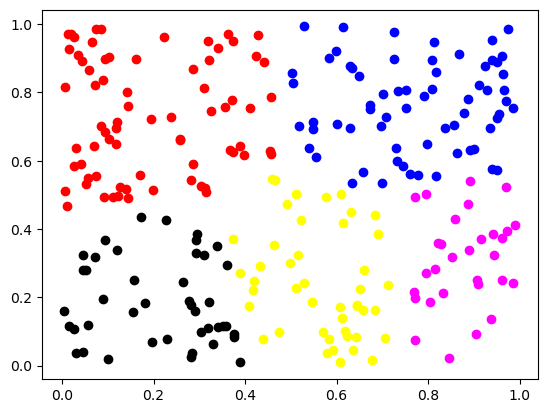

In [9]:
for label_value, label_color in label_color_map.items():
    index = (labels == label_value)
    plt.plot(data[index, 0], data[index, 1], 'o', color=label_color)